# K-Means Clustering on the data set

## Libraries

In [3]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
random.seed(1)
from sklearn.preprocessing import normalize

## Importing the data set
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

In [4]:
# IMPORTANT: Filepath depends on OS!
df = pd.read_csv(r'data/hmnist_28_28_L.csv')
print(df) # Shape (#images, h*w+1) (here: (10015, 785))

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            169        171        170        177        181        182   
1             19         57        105        140        149        148   
2            155        163        161        167        167        172   
3             25         71        116        139        136        153   
4            129        162        181        196        205        208   
...          ...        ...        ...        ...        ...        ...   
10010        172        171        173        175        164        187   
10011          2         34        108        116        114        119   
10012        122        154        162        170        179        197   
10013        137        143        141        139        147        152   
10014        149        157        157        152        151        152   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
0            181   

## Displaying an image

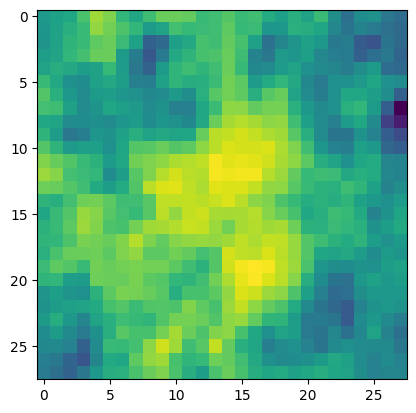

(785,)
150
pixel0000    150
pixel0001    155
pixel0002    158
pixel0003    177
pixel0004    199
            ... 
pixel0780    143
pixel0781    135
pixel0782    137
pixel0783    137
label          0
Name: 9869, Length: 785, dtype: int64


In [5]:
def disp_img(data_vec):
    # Handle the cases of whether the label for an image is provided or not
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    plt.show()


img_number = 9869 # Index of a particular data image
data_vec = df.loc[img_number]

disp_img(data_vec)

print(data_vec.shape)
print(data_vec[0])
print(data_vec)

## Count occurences of labels

Count the number of data images corresponding to each label.

In [6]:
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)

# Each tuple will contain a label and the number of images with the same label
# [(label, #occurences), ..]
occurences = list(zip(uniq_label, counts_label))
print(occurences)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Partition the images into the different classes
Create a list of nested lists. Each nested list represents a label and contains the indices of all data images with the same label. E.g. img_index_group[2] contains all images for label 2.

In [7]:
# List of 7 nested lists (for each diagnostical categorie)
# The ith nested list contains the indices of all images, which correspond to label i
# E.g. img_index_group[2] contains all images for label 2
img_index_group = []

for i in range(len(uniq_label)):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)

# Output would exceed the size limit
# print(img_index_group)

# For debugging purposes
# print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))

# Splitting into training and testing data

In [8]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(len(img_index_group)):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

#print(img_index_group_split)

## Merging the different training data sets into one and discaring the labels

## K-Means Clustering

In [9]:
def calcSqDistances(data, Kmus):
    return ((-2 * data.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(data, data), axis=1)).T


def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]


def recalcMus(data, Rnk):
    return (np.divide(data.T.dot(Rnk), np.sum(Rnk, axis=0))).T



classes = 7 # Number of diagnostical categories
max_iterations = 1000


images = df.to_numpy()
# Remove the labels
images = images[:, 0:-1]  # arr: Shape: (#images, #pixels)

n = images.shape[0]
dim = images.shape[1]

# Initialize cluster centers by randomly picking points from the data
rndinds = np.random.permutation(n)
k_mus = images[rndinds[:classes]]


for iter in range(max_iterations):
    sqDmat = calcSqDistances(images, k_mus)
    rank = determineRnk(sqDmat)
    k_mus_old = k_mus
    k_mus = recalcMus(images, rank)

    if sum(abs(k_mus_old.flatten() - k_mus.flatten())) < 1e-6:
        break


# for i in range(classes):
#     disp_img(k_mus[i])


## Compare the computed means with the actual means
The mean images computed using the K-means algorithm are on the lefthand side of each plot. The actual means for each label are on the righthand side.

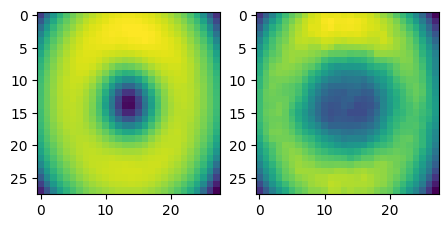

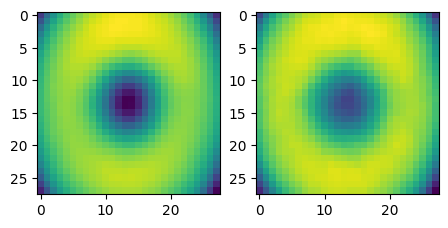

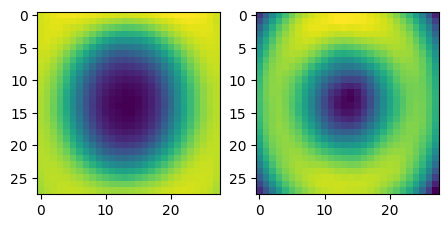

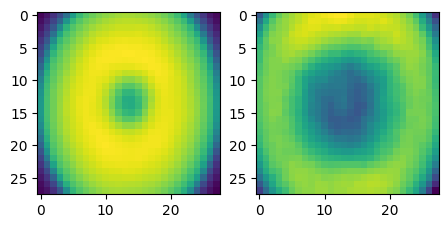

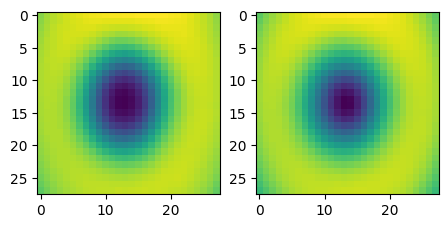

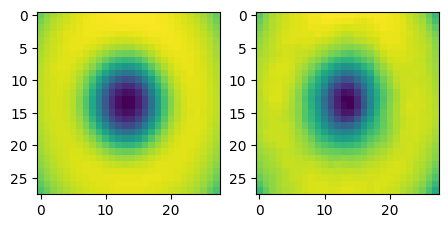

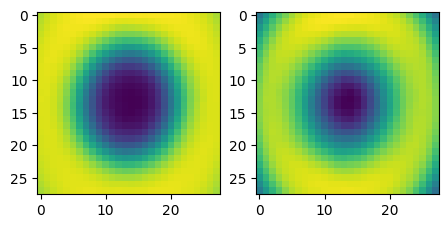

In [11]:
mean = []

for i in range(len(img_index_group)):
    mean.append(np.mean(df.loc[img_index_group[i]], axis=0))
    
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(np.reshape(k_mus[i], (28, 28)))
    plt.subplot(1, 3, 2)
    disp_img(mean[i])



## Matching the calculated clusters to the different diagnosis

## Feeding the training data and calculating the accuracy